<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

# Kriging vs. Simulation, 2D Maps

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Spatial Estimation with Kriging vs. Simulation with Sequential Gaussian Simulation (SGSIM)** with a 2D map example.

* this is the fluctuations in the reproduction of input statistics over multiple simulation realizations.

**YouTube Lecture**: check out my lecture on [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). For your convenience here's a summary of salient points.

#### Estimation vs. Simulation

Let's start by comparing spatial estimation and simulation.

Estimation: 

* honors local data 
* locally accurate, primary goal of estimation is 1 estimate! 
* too smooth, appropriate for visualizing trends 
* too smooth, inappropriate for flow simulation 
* one model, no assessment of global uncertainty 

Simulation: 

* honors local data 
* sacrifices local accuracy, reproduces histogram 
* honors spatial variability, appropriate for flow simulation 
* alternative realizations, change random number seed 
* many models (realizations), assessment of global uncertainty

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
\end{equation}

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
\end{equation}

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

\begin{equation}
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
\end{equation}

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

\begin{equation}
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
\end{equation}

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

\begin{equation}
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
\end{equation}

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

##### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

I have more on this topic at [Krigign YouTube Lecture](https://youtu.be/CVkmuwF8cJ8).

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

In this workflow we run kriging estimates and multiple simulation realizations, and compare the statistics.

#### Load the required libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms.

In [3]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill,mcolor,rcolor,size,legend_pos): # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'dark'+rcolor,edgecolor = 'black',s = npps_maj*0.15*size,lw=2,
        label = 'Experimental Major', alpha = 0.8,zorder=60)
    plt.scatter(lags,gamma_min,color = rcolor,edgecolor = 'black',s = npps_min*0.10*size,lw=1,alpha = 0.8,
        label='Experimental Minor')
    plt.scatter(lags,gamma_maj,color = 'white',edgecolor = 'white',s = npps_maj*0.35*size,lw=2,
        alpha = 0.8,zorder=50)
    plt.plot(lags_maj,gmod_maj,color = 'dark'+mcolor,lw=3,label = 'Model Major',zorder=80)
    plt.plot(lags_maj,gmod_maj,color = 'white',lw=6*size,zorder=70)

    plt.plot(lags_min,gmod_min,color = mcolor,lw=1.5,label='Model Minor',zorder=60)
    plt.plot(lags_min,gmod_min,color = 'white',lw=3.0,zorder=50)
    plt.plot([0,2000],[sill,sill],color = 'black',zorder=30)
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); plt.ylim([0,1.8*sill])
    plt.legend(loc=legend_pos)
    plt.grid(True)
    
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step))
    cs = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
    plt.scatter(df[xcol],df[ycol],s=20,c=df[vcol],marker='o',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,edgecolors='black',zorder=2)
    plt.scatter(df[xcol],df[ycol],s=40,c='white',marker='o',alpha=0.8,linewidths=0.8,edgecolors=None,zorder=1)
    plt.title(title); plt.xlabel(xlabel)
    plt.ylabel(ylabel); plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    cbar = plt.colorbar(cs,orientation="vertical",cmap=cmap)
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* note the "fraction_data" variable is an option to random take part of the data (i.e., 1.0 is all data).

    * this is not standard part of spatial estimation, but fewer data is easier to visualize given our grid size (we want multiple cells between the data to see the behavoir away from data)

* note, I often remove unnecessary data table columns. This clarifies workflows and reduces the chance of blunders, e.g., using the wrong column!

In [5]:
fraction_data = 0.2                                           # extract a fraction of data for demonstration / faster runs, set to 1.0 for homework

df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df = df.rename(columns = {'Por':'Porosity'})                  # rename feature(s)
df = df.sample(frac = fraction_data,replace = False,random_state=13) # random sample from the dataset
df = df.reset_index()                                         # reset the record index 
df = df.loc[:,['X','Y','Porosity']];                          # retain only x, y and porosity
df.head()

,X,Y,Porosity
0,390.800194,460.553846,5.774823
1,380.012934,519.379612,11.577469
2,885.824011,866.827752,13.808706
3,885.845177,355.124942,11.786347
4,855.906100,656.141070,10.422411


#### Set Limits for Plotting, Colorbars and Grid Specification

Limits are applied for data and model visualization and the grid parameters sets the coverage and resolution of our map.

In [6]:
xmin = 0.0; xmax = 1000.0                                     # spatial limits
ymin = 0.0; ymax = 1000.0

nx = 100; xmn = 5.0; xsiz = 10.0                              # grid specification
ny = 100; ymn = 5.0; ysiz = 10.0

pormin = 0.0; pormax = 22.0                                   # feature limits
porvar = np.var(df['Porosity'].values)                        # assume data variance is representative

tmin = -9999.9; tmax = 9999.9                                 # triming limits

#### Data Analytics and Visualization

Let's take a look at the available data:

* location map
* histogram
* variogram

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
 x,y,z offsets = 0.0,10.0


 x,y,z offsets = 10.0,1.794896514920806e-08


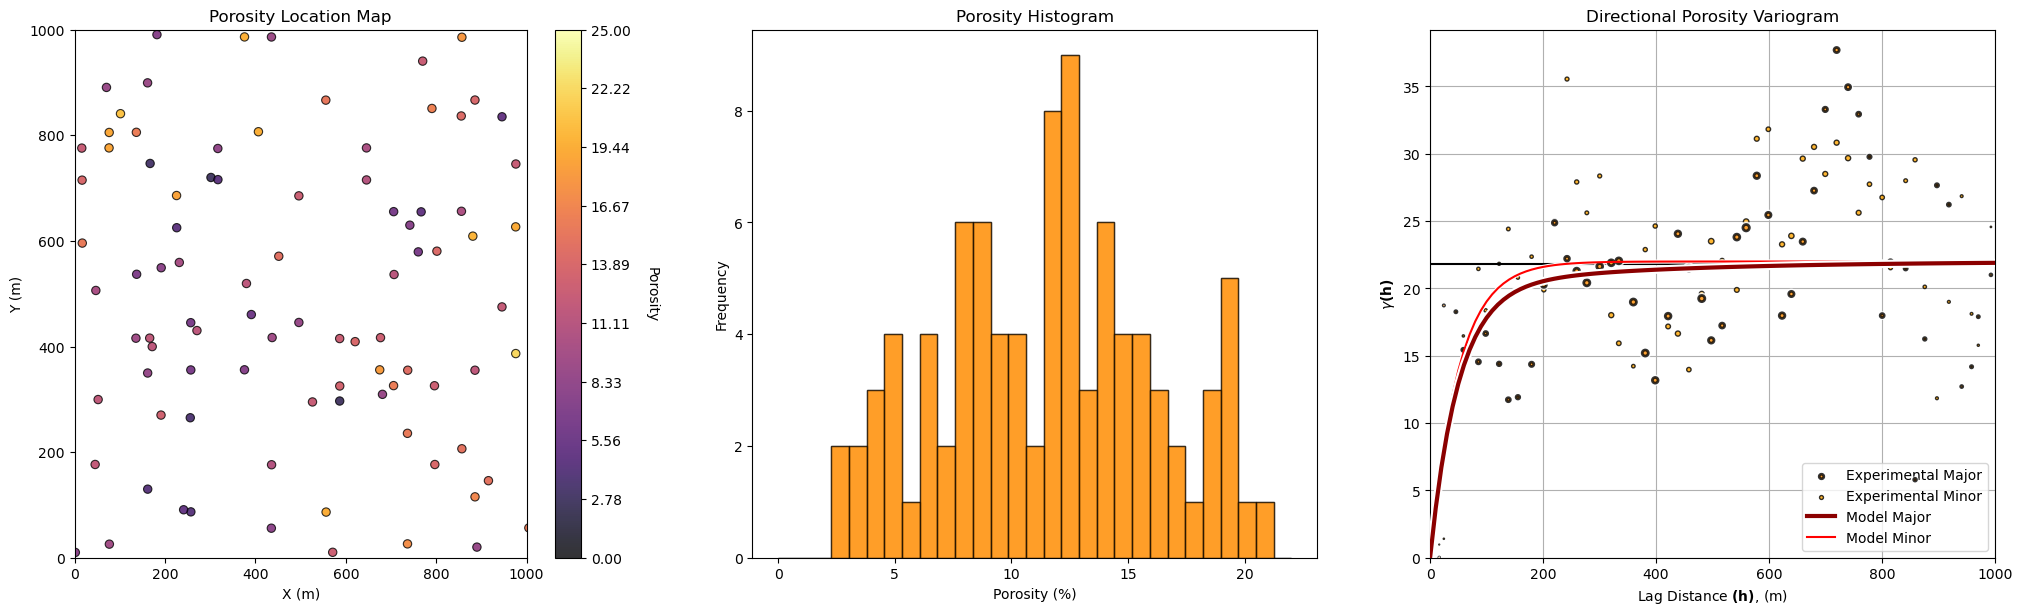

In [7]:
plt.subplot(131)                                              # location map
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,25,'Porosity Location Map','X (m)','Y (m)','Porosity',cmap=cmap)

plt.subplot(132)                                              # histogram
plt.hist(df['Porosity'].values,bins=np.linspace(pormin,pormax,30),color='darkorange',alpha=0.6,edgecolor='black',
         label = 'Porosity')
plt.hist(df['Porosity'].values,bins=np.linspace(pormin,pormax,30),color='darkorange',alpha=0.6,edgecolor='black',
         label = 'Porosity')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')

plt.subplot(133)                                              # variogram

lags, gamma_maj, npps_maj = geostats.gamv(df,"X","Y",'Porosity',tmin,tmax,xlag=20,xltol=20,nlag=100,azm=0.0,atol=22.5,bandwh=9999.9,isill=0);
lags, gamma_min, npps_min = geostats.gamv(df,"X","Y",'Porosity',tmin,tmax,xlag=20,xltol=20,nlag=100,azm=90.0,atol=22.5,bandwh=9999.9,isill=0);

nug = 0; nst = 2                                              # 2 nest structure variogram model parameters
it1 = 2; cc1 = 20.0; azi1 = 0; hmaj1 = 150; hmin1 = 150
it2 = 2; cc2 = 2.0; azi2 = 0; hmaj2 = 1000; hmin2 = 150

vmodel = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2); # make model object
vmodel_sim = GSLIB.make_variogram(nug,nst,it1,cc1/(cc1+cc2),azi1,hmaj1,hmin1,it2,cc2/(cc1+cc2),azi2,hmaj2,hmin2); # make model object

vargplot('Porosity',lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar,mcolor='red',rcolor='orange',size=1.0,
         legend_pos='lower right')                            # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

##### Simple Kriging Estimation Map of Porosity

Let's specify the variogram model, global stationary mean and variance, and kriging parameters.

In [8]:
vrange_maj = 250; vrange_min = 100                            # variogram ranges
vazi = 150.0                                                  # variogram major direction
vrel_nugget = 0.0                                             # variogram nugget effect

skmean = np.average(df['Porosity'].values)                    # assume global mean is the mean of the sample
sill = np.var(df['Porosity'].values)                          # assume sill is variance of the sample

por_vario = GSLIB.make_variogram(nug=vrel_nugget*sill,nst=1,it1=1,cc1=(1.0-vrel_nugget)*sill,
         azi1=vazi,hmaj1=vrange_maj,hmin1=vrange_min)         # porosity variogram

ktype = 0                                                     # kriging type, 0 - simple, 1 - ordinary
radius = 600                                                  # search radius for neighbouring data
nxdis = 1; nydis = 1                                          # number of grid discretizations for block kriging
ndmin = 0; ndmax = 10                                         # minimum and maximum data for an estimate

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


Now let's pass this to kriging to make our porosity kriging estimate map.

  Estimated   10000 blocks 
      average   11.640125112287828  variance  5.16264561085336


 x,y,z offsets = 0.0,10.0
 x,y,z offsets = 10.0,1.794896514920806e-08


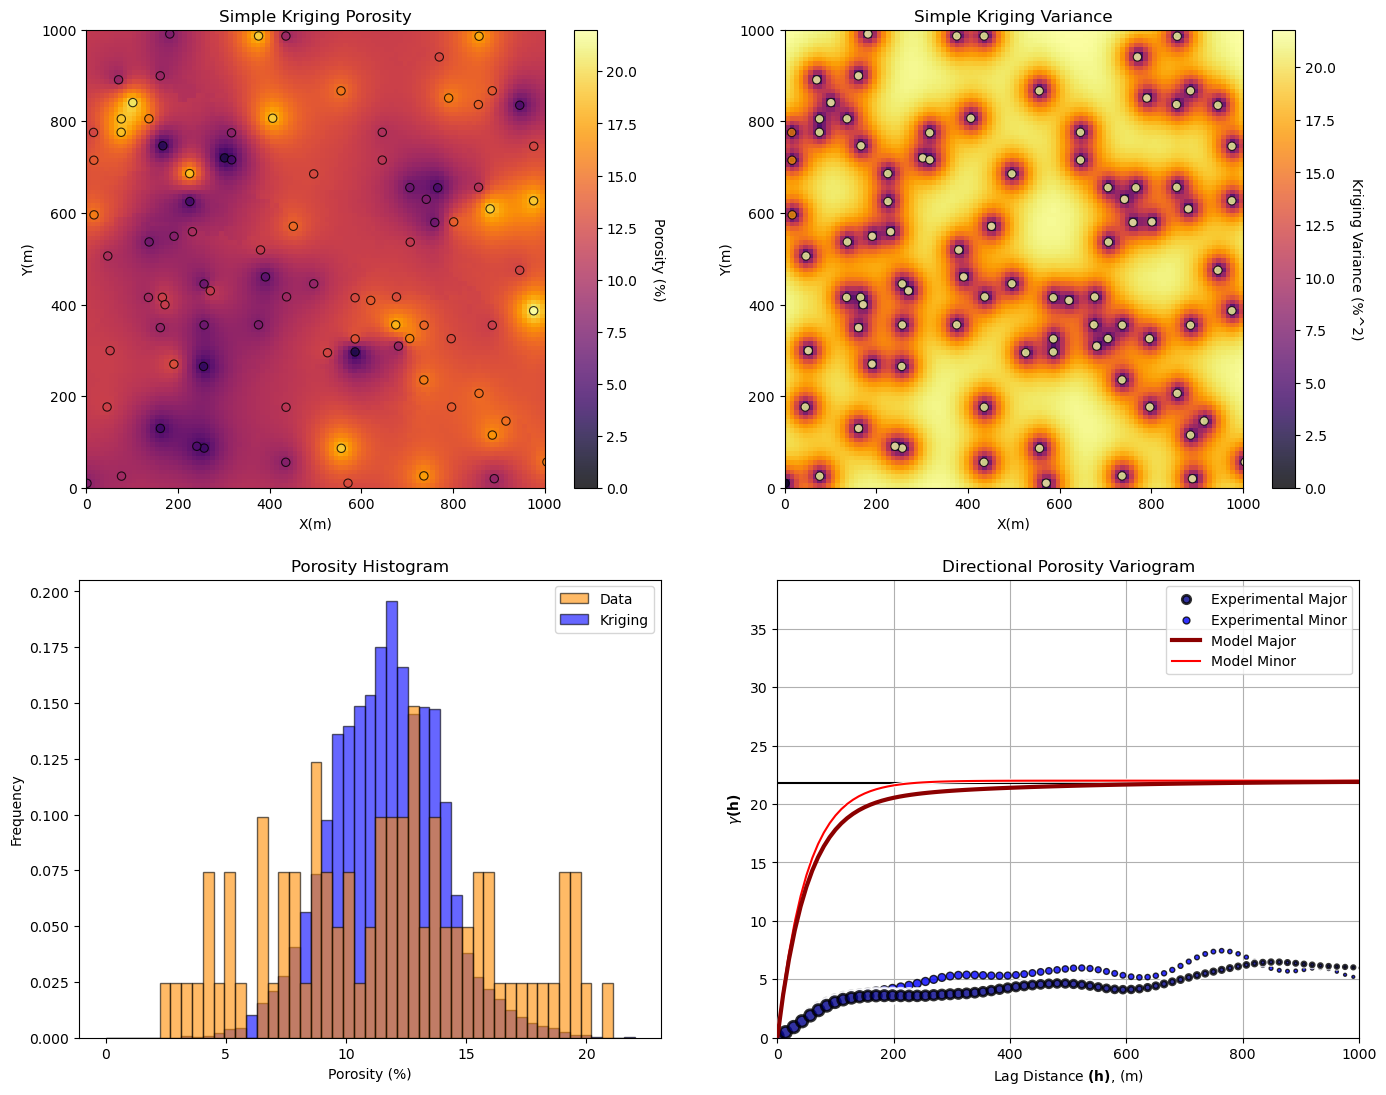

In [9]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=1,nydis=1,
         ndmin=0,ndmax=10,radius=500,ktype=0,skmean=skmean,vario=vmodel)

plt.subplot(221)                                              # kriging estimation map
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Simple Kriging Porosity',
        'X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)                                              # kriging variance map
GSLIB.locpix_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0,sill,df,'X','Y','X','Simple Kriging Variance','X(m)','Y(m)',
        'Kriging Variance (%^2)',cmap)

plt.subplot(223)                                              # histograms
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='darkorange',alpha=0.6,
    edgecolor='black',label='Data',zorder=10)
plt.hist(por_kmap.flatten(),density=True,bins=np.linspace(pormin,pormax,50),color='blue',alpha=0.6,
    edgecolor='black',label='Kriging',zorder=1)
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram'); plt.legend(loc='upper right')

lags, sk_gamma_maj, npps_maj = geostats.gam(por_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=-1,nlag=100,isill=0.0);
lags, sk_gamma_min, npps_min = geostats.gam(por_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=1,nlag=100,isill=0.0);

plt.subplot(224)                                               # experimental variograms
vargplot('Porosity',lags,sk_gamma_maj,sk_gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar,
         mcolor = 'red', rcolor = 'blue',size= 0.05,legend_pos = 'upper right')                # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average              = 11.6441
                 Weighted Variance             = 21.7855
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9861
Setting up rotation matrices for variogram and search


Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0028 (close to 0.0?)
                                   variance = 1.1631 (close to gammabar(V,V)? approx. 1.0)


 x,y,z offsets = 0.0,10.0
 x,y,z offsets = 10.0,1.794896514920806e-08


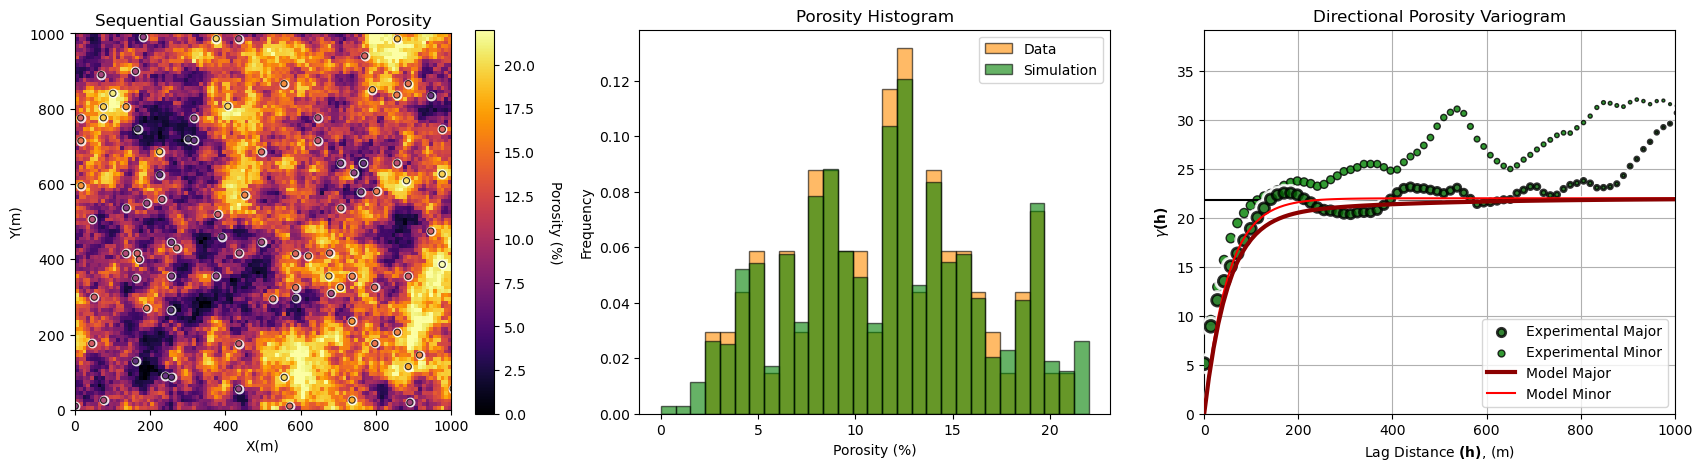

In [10]:
run = True                                                    # run the realizations, it will likely take minutes to complete

if run:
    por_sim_one = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=0,ndmax=20,nodmax=20,mults=0,nmult=2,noct=-1,
            ktype=0,colocorr=0.0,sec_map=0,vario=vmodel_sim)[0]

plt.subplot(131)                                              # pixelplot and location map
locpix_st(por_sim_one,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Sequential Gaussian Simulation Porosity','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(132)                                              # histograms
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,30),color='darkorange',alpha=0.6,edgecolor='black',label='Data')
plt.hist(por_sim_one.flatten(),density=True,bins=np.linspace(pormin,pormax,30),color='green',alpha=0.6,edgecolor='black',label='Simulation')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram'); plt.legend(loc='upper right')

lags, sim_gamma_maj, npps_maj = geostats.gam(por_sim_one,tmin,tmax,xsiz,ysiz,ixd=1,iyd=-1,nlag=100,isill=0.0);
lags, sim_gamma_min, npps_min = geostats.gam(por_sim_one,tmin,tmax,xsiz,ysiz,ixd=1,iyd=1,nlag=100,isill=0.0);

plt.subplot(133)                                              # variograms 
vargplot('Porosity',lags,sim_gamma_maj,sim_gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar,
        mcolor = 'red', rcolor = 'green',size= 0.05,legend_pos = 'lower right')     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=0.8, wspace=0.2, hspace=0.2); plt.show()

#### Visualize Simulated Realizations and a Kriged Estimation Model


 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average              = 11.6441
                 Weighted Variance             = 21.7855
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9861
Setting up rotation matrices for variogram and search


Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0028 (close to 0.0?)
                                   variance = 1.1631 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 1
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 1: number   = 10000
                                   mean     = -0.0191 (close to 0.0?)
                                   variance = 0.9724 (close to gammabar(V,V)? approx. 1.0)
Working on realization number 2
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 2: number   = 10000
                                   mean     = 0.0618 (close to 0.0?)
                                   variance = 1.0912 (close to gammabar(V,V)? approx. 1.0)


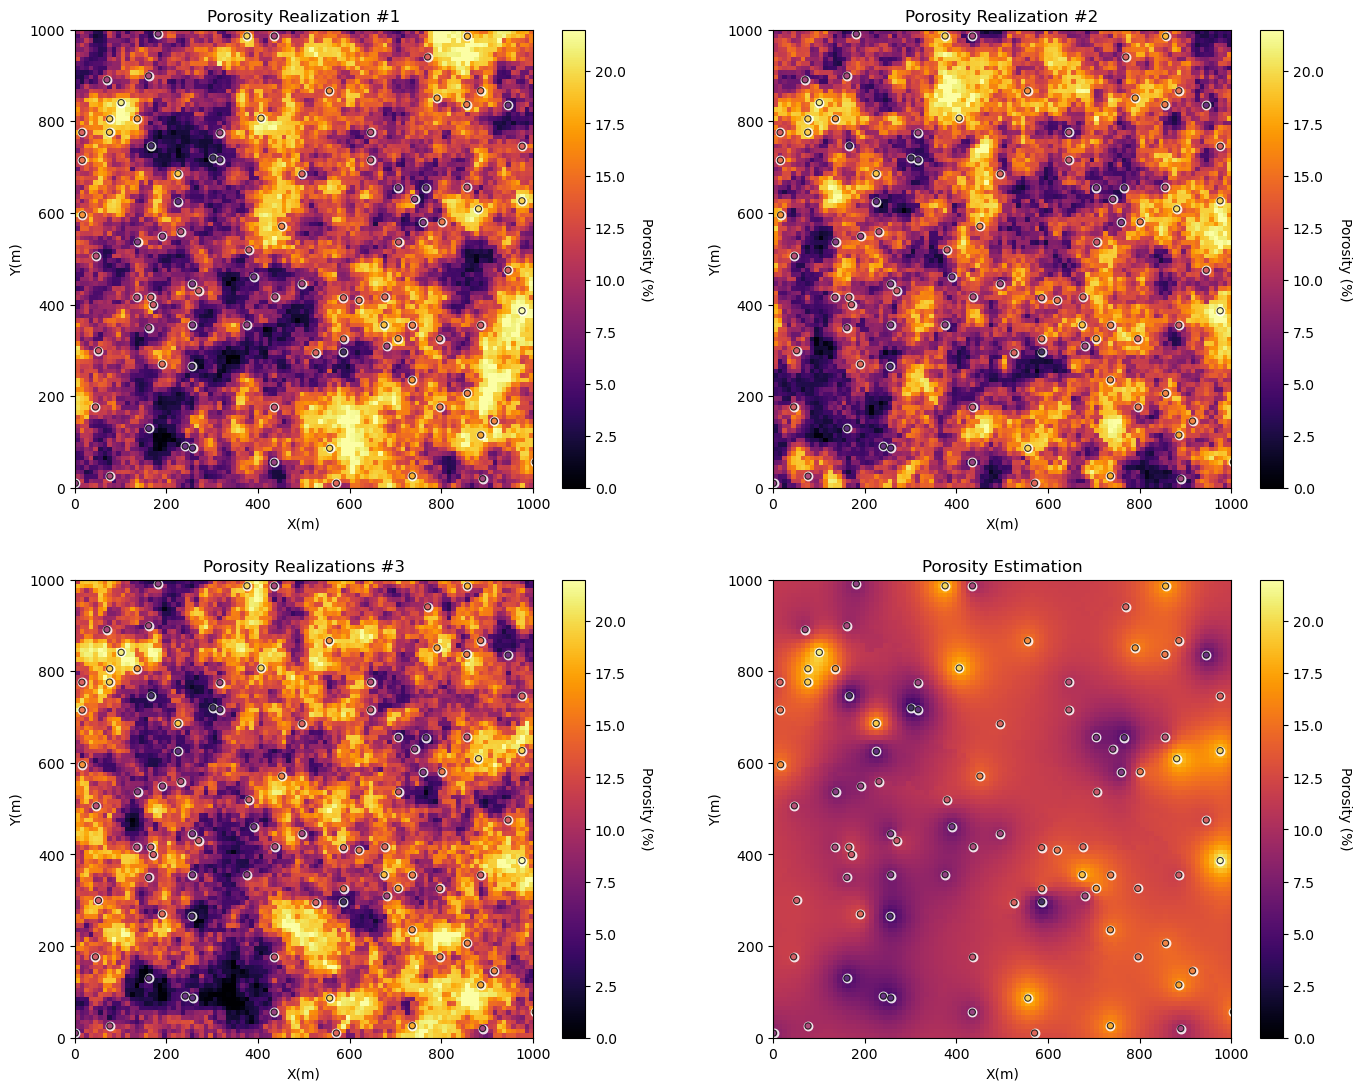

In [11]:
run = True                                                    # run the realizations, it will likely take minutes to complete
plt.subplot(131)                                              
if run:
    por_sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=3,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=0,ndmax=20,nodmax=20,mults=0,nmult=2,noct=-1,
            ktype=0,colocorr=0.0,sec_map=0,vario=vmodel_sim)

plt.subplot(221)                                               # pixelplot and location map
locpix_st(por_sim[0],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Porosity Realization #1','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)                                               # pixelplot and location map
locpix_st(por_sim[1],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Porosity Realization #2','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)                                               # pixelplot and location map
locpix_st(por_sim[2],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Porosity Realizations #3','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(224)                                               # pixelplot and location map
locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Porosity Estimation','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration and comparison of spatial estimation vs. spatial simulation with kriging and sequential Gaussian simulation from GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  